# Dates

On va essayer de trouver le meilleur moyen de tirer parti des dates de consommation. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import sys
sys.path.append("../scripts/")

# librairies perso
from make_train_test_set import make_train_test_set
from import_data import import_data
from metrics import metrics 
from group_by_clients import group_by_clients

In [2]:
data = pd.read_csv("../data/dataset_modify").drop("Unnamed: 0", axis = 1)
data["horodate"] = pd.to_datetime(data["horodate"])

In [3]:
data["day"] = data["horodate"].dt.day
data["month"] = data["horodate"].dt.month
data["year"] = data["horodate"].dt.year

### Données test / train

In [4]:
clients = group_by_clients(data)
n = len(clients)

In [5]:
X_train, X_test, y_train, y_test, test_data = make_train_test_set(clients, ["day", "month", "year", "forecasted_consumption"], ["real_consumption"])

### Création des modèles

In [6]:
models = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models): 
    model.fit(X_train[i], y_train[i])

In [7]:
y_pred = []
for i, model in enumerate(models) : 
    y_pred.append(model.predict(X_test[i]).reshape(len(X_test[i])))

### Evaluation des modèles

In [8]:
evaluation_model = []
evalutation_airliquide_model = []
for i in range(n): 
    evaluation_model.append(metrics(test_data[i]["real_consumption"], y_pred[i]))
    evalutation_airliquide_model.append(metrics(test_data[i]["real_consumption"], test_data[i]["prediction"]))

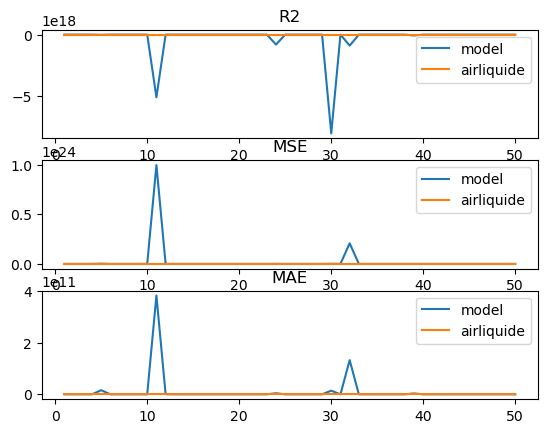

In [9]:
X = list(range(1,n+1))
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model], label = "model")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

on voit directement que c'est très mauvais

### Feature importance

In [10]:
def display_feat_imp(models):
    k = len(models)
    feat_imp_reg = 0
    for model in models: 
        feat_imp_reg += model.coef_[0]
    feat_imp_reg /= k
    feat_importance = pd.DataFrame(columns = ["Feature Name", "Feature Importance"])
    feat_importance["Feature Name"] = pd.Series(model.feature_names_in_)
    feat_importance["Feature Importance"] = pd.Series(feat_imp_reg)
    feat_importance.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")

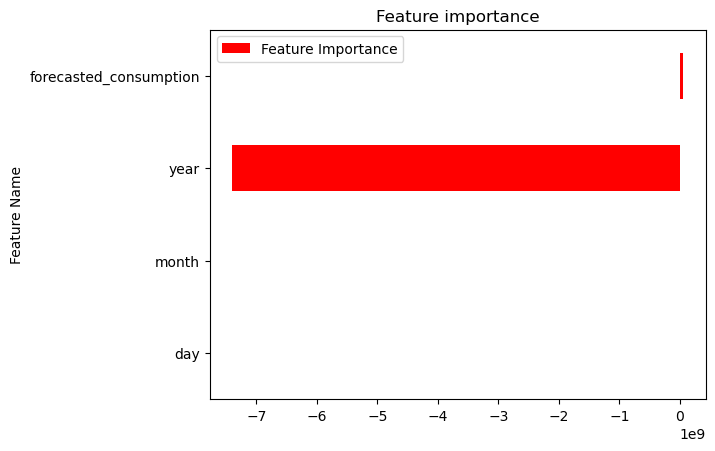

In [11]:
display_feat_imp(models)

## On enlève l'année 

### Données train / test 

In [41]:
clients = group_by_clients(data)
n = len(clients)

In [68]:
X_train, X_test, y_train, y_test, test_data = make_train_test_set(clients, ["day", "forecasted_consumption"], ["real_consumption"])

### Création des modèles

In [69]:
models = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models): 
    model.fit(X_train[i], y_train[i])

In [70]:
y_pred = []
for i, model in enumerate(models) : 
    y_pred.append(model.predict(X_test[i]).reshape(len(X_test[i])))

### Evaluation des modèles

In [71]:
evaluation_model = []
evalutation_airliquide_model = []
for i in range(n): 
    evaluation_model.append(metrics(test_data[i]["real_consumption"], y_pred[i]))
    evalutation_airliquide_model.append(metrics(test_data[i]["real_consumption"], test_data[i]["prediction"]))

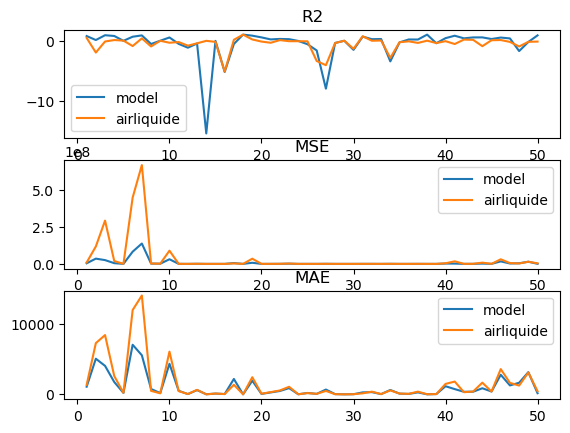

In [72]:
X = list(range(1,n+1))
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model], label = "model")
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

### Feature importance

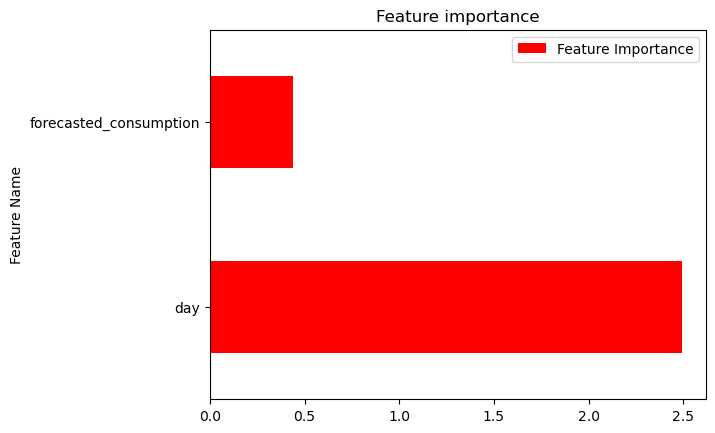

In [73]:
display_feat_imp(models)

## Comparaison entre ce modèle et seulement les prédictions 

In [74]:
clients = group_by_clients(data)
n = len(clients)

In [75]:
X_train, X_test, y_train, y_test, test_data = make_train_test_set(clients, ["forecasted_consumption"], ["real_consumption"])

In [76]:
models_base = [LinearRegression() for _ in range(n)]
for i, model in enumerate(models_base): 
    model.fit(X_train[i], y_train[i])

In [77]:
y_pred_base = []
for i, model in enumerate(models_base) : 
    y_pred_base.append(model.predict(X_test[i]).reshape(len(X_test[i])))

In [78]:
evaluation_model_base = []
evalutation_airliquide_model = []
for i in range(n): 
    evaluation_model_base.append(metrics(test_data[i]["real_consumption"], y_pred_base[i]))
    evalutation_airliquide_model.append(metrics(test_data[i]["real_consumption"], test_data[i]["prediction"]))

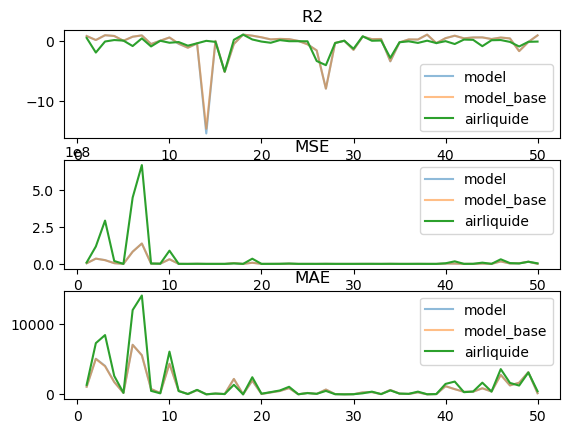

In [79]:
X = list(range(1,n+1))
fig, ax = plt.subplots(3)
ax[0].set_title("R2")
ax[1].set_title("MSE")
ax[2].set_title("MAE")
for i in range(3): 
    ax[i].plot(X, [x[i] for x in evaluation_model], label = "model", alpha = 0.5)
    ax[i].plot(X, [x[i] for x in evaluation_model_base], label = "model_base", alpha = 0.5)
    ax[i].plot(X, [x[i] for x in evalutation_airliquide_model], label = "airliquide")
    ax[i].legend()

Il n'y a pas beaucoup de différence. 

In [80]:
for i in range(1,3):
    print(sum([x[i] for x in evaluation_model]), sum([x[i] for x in evaluation_model_base]))

386893280.6210004 386408243.3685898
52715.32230742376 52589.064411965745


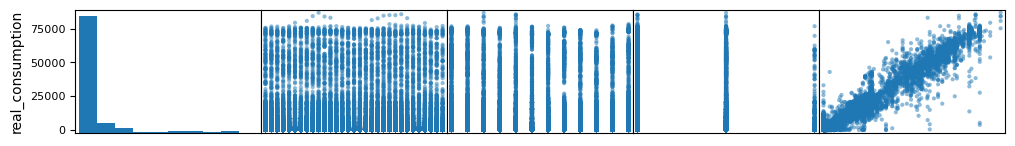

In [132]:
attributes = [ "real_consumption","day", "month", "year","forecasted_consumption"]
axes = pd.plotting.scatter_matrix(data[attributes], figsize=(12, 8))

# Masquer les sous-parcelles sauf la première ligne
for i, row in enumerate(axes):
    if i == 0 : 
        for j, subplot in enumerate(row) : 
            subplot.set_xlabel(attributes[j])
    else :
        for subplot in row : 
            subplot.set_visible(False)

# Afficher la matrice de dispersion
plt.show()

In [133]:
data

,id_client,horodate,real_consumption,forecasted_consumption,prediction,day,month,year
0,1,2021-01-01,8396.00,8400.0,8323.319457,1,1,2021
1,1,2021-01-02,8395.00,8400.0,8194.785384,2,1,2021
2,1,2021-01-03,8396.00,8400.0,8183.265980,3,1,2021
3,1,2021-01-04,8397.00,8400.0,8420.826672,4,1,2021
4,1,2021-01-05,8395.73,8400.0,8123.422185,5,1,2021
...,...,...,...,...,...,...,...,...
38044,50,2023-01-27,0.00,0.0,0.000000,27,1,2023
38045,50,2023-01-28,0.00,0.0,0.000000,28,1,2023
38046,50,2023-01-29,0.00,0.0,0.000000,29,1,2023
38047,50,2023-01-30,0.00,0.0,0.000000,30,1,2023
